In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.4 MB/s eta 0:00:00


In [ ]:
!pip install retina-face

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 모델 생성

In [ ]:
from facenet_pytorch import InceptionResnetV1

def make_age_model():
    model = InceptionResnetV1(classify=True, pretrained='vggface2', num_classes=1)
    in_dim = model.logits.in_features
    model.logits = nn.Linear(in_dim, 1)
    return model

def load_model(model, path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

age = make_age_model()

age_model_path = '/content/drive/MyDrive/DL_DATA/DL_Face_REC/Final_Model/age_model_checkpoint_epoch_10_loss_4.57.pth'
age_model = load_model(age, age_model_path)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
class Gender_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)
        x = x.squeeze()
        return x

gender_model_path = '/content/drive/MyDrive/DL_DATA/DL_Face_REC/Final_Model/gender_model_v3_checkpoint_epoch_19.pth'
gender = Gender_Net()
gender_model = load_model(gender, gender_model_path)

In [ ]:
def process_input(img, box):
    img_ar = img[box[1]:box[3], box[0]:box[2]]
    img_ar = cv2.resize(img_ar, (224, 224))
    image = Image.fromarray(img_ar)

    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.6284, 0.4901, 0.4325], std=[0.1869, 0.1712, 0.1561]),
    ])
    img_tensor = preprocess(image).unsqueeze(0)  # 배치 차원 추가
    return img_tensor

In [ ]:
def predict_age(image, model):
    image = image.to(device)
    model = model.to(device)

    model.eval()
    with torch.no_grad():
        prediction = model(image)

    return prediction.item()

In [ ]:
def predict_gender(image, model):
    image = image.to(device)
    model = model.to(device)

    model.eval()
    with torch.no_grad():
        logit = model(image)
        pred = torch.sigmoid(logit)
        output = 'Male' if pred.item() < 0.5 else 'Female'

    return output

# 이미지 시각화

In [ ]:
from retinaface import RetinaFace

image_path = '/content/drive/MyDrive/DL_DATA/DL_Face_REC/test_image/초등학생.png'

In [ ]:
def visualize_predictions(image_path, age_model, gender_model):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    resp = RetinaFace.detect_faces(img_rgb)

    pic = img.copy()
    for face in resp.values():
        box = face['facial_area']

        img_tensor = process_input(img_rgb, box)
        age = int(predict_age(img_tensor, age_model))
        gender = predict_gender(img_tensor, gender_model)

        if gender == 'Male':
            color = (255, 0, 0)
        else:
            color = (0, 0, 255)

        cv2.rectangle(pic, (box[0], box[1]), (box[2], box[3]), color=(0, 255, 0), thickness=1)
        cv2.putText(pic, f"Gender: {gender}", (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        cv2.putText(pic, f"Age: {age}", (box[0], box[1]-25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    cv2_imshow(pic)

24-03-05 13:37:57 - Directory /root/.deepface created
24-03-05 13:37:57 - Directory /root/.deepface/weights created
24-03-05 13:37:57 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:00<00:00, 150MB/s]


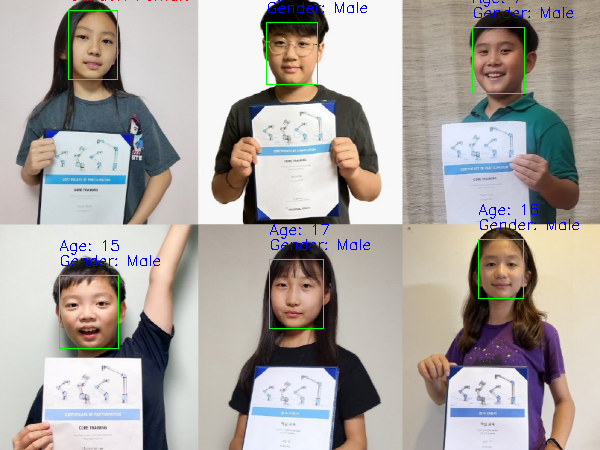

In [ ]:
visualize_predictions(image_path, age_model, gender_model)

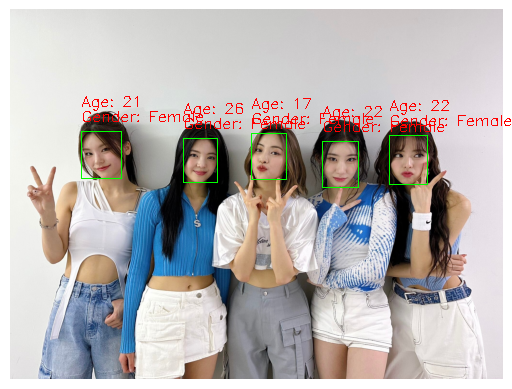

In [ ]:
image_path = '/content/drive/MyDrive/DL_DATA/DL_Face_REC/test_image/itzy.png'
visualize_predictions(image_path, age_model, gender_model)

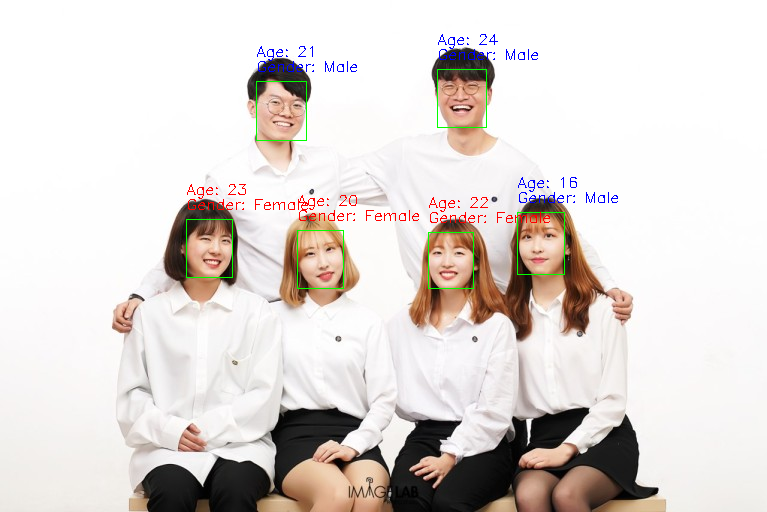

In [ ]:
image_path = '/content/drive/MyDrive/DL_DATA/DL_Face_REC/test_image/대학생.jpg'
visualize_predictions(image_path, age_model, gender_model)

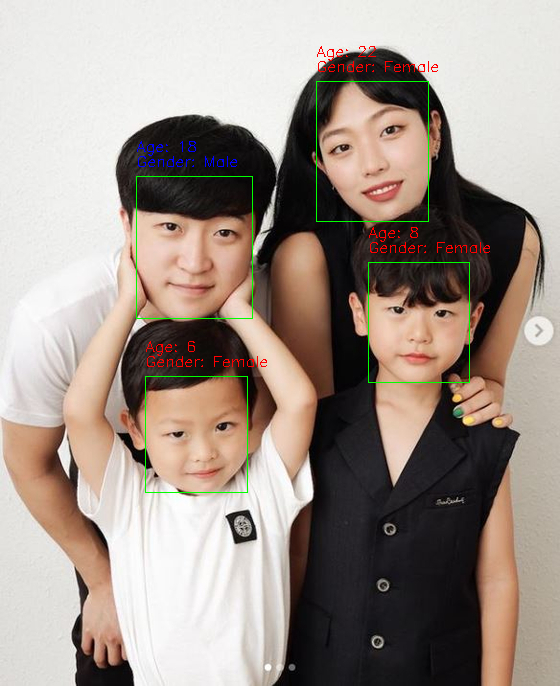

In [ ]:
image_path = '/content/drive/MyDrive/DL_DATA/DL_Face_REC/test_image/부부.jpg'
visualize_predictions(image_path, age_model, gender_model)

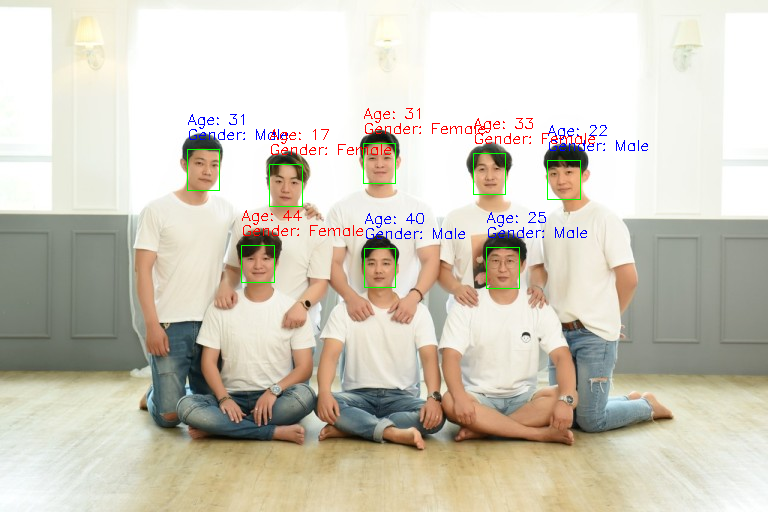

In [ ]:
image_path = '/content/drive/MyDrive/DL_DATA/DL_Face_REC/test_image/남자 단체.jpg'
visualize_predictions(image_path, age_model, gender_model)

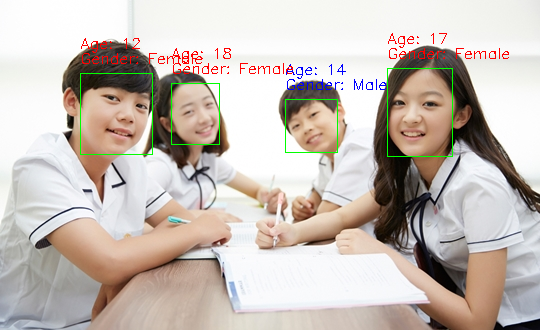

In [ ]:
image_path = '/content/drive/MyDrive/DL_DATA/DL_Face_REC/test_image/중학생.jpg'
visualize_predictions(image_path, age_model, gender_model)

# 동영상 시각화

In [ ]:
!mkdir /content/output/

In [ ]:
import time

video_input_path = '/content/drive/MyDrive/DL_DATA/DL_Face_REC/test_image/테스트_영상.mp4'
video_output_path = '/content/output/test_output_RetinaFace.mp4'

cap = cv2.VideoCapture(video_input_path)
codec = cv2.VideoWriter_fourcc(*'mp4v')

vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
vid_fps = cap.get(cv2.CAP_PROP_FPS )

vid_writer = cv2.VideoWriter(video_output_path, codec, vid_fps, vid_size)

frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('총 Frame 갯수:', frame_cnt, 'FPS:', round(vid_fps), 'Frame 크기:', vid_size)

총 Frame 갯수: 23432 FPS: 30 Frame 크기: (1280, 720)


In [ ]:
green_color=(0, 255, 0)
red_color=(0, 0, 255)

start = time.time()
index=0
while True:
    hasFrame, img_frame = cap.read()

    if not hasFrame or index >= 300:
        print('더 이상 처리할 frame이 없습니다.')
        break

    if hasFrame:
        img_frame_rgb = cv2.cvtColor(img_frame, cv2.COLOR_BGR2RGB)
        resp = RetinaFace.detect_faces(img_frame_rgb)

        pic = img_frame.copy()
        for face in resp.values():
            box = face['facial_area']
            img_tensor = process_input(img_frame_rgb, box)

            age = int(predict_age(img_tensor, age_model))
            gender = predict_gender(img_tensor, gender_model)

            if gender == 'Male':
                color = (255, 0, 0)
            else:
                color = (0, 0, 255)

            cv2.rectangle(pic, (box[0], box[1]), (box[2], box[3]), color=(0, 255, 0), thickness=1)
            cv2.putText(pic, f"Gender: {gender}", (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            cv2.putText(pic, f"Age: {age}", (box[0], box[1]-25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    index += 1
    if index % 10 == 0:
        print('frame :', index, '처리 완료')

    vid_writer.write(pic)

print('write 완료 시간:', round(time.time()-start,4))
vid_writer.release()
cap.release()

frame : 10 처리 완료
frame : 20 처리 완료
frame : 30 처리 완료
frame : 40 처리 완료
frame : 50 처리 완료
frame : 60 처리 완료
frame : 70 처리 완료
frame : 80 처리 완료
frame : 90 처리 완료
frame : 100 처리 완료
frame : 110 처리 완료
frame : 120 처리 완료
frame : 130 처리 완료
frame : 140 처리 완료
frame : 150 처리 완료
frame : 160 처리 완료
frame : 170 처리 완료
frame : 180 처리 완료
frame : 190 처리 완료
frame : 200 처리 완료
frame : 210 처리 완료
frame : 220 처리 완료
frame : 230 처리 완료
frame : 240 처리 완료
frame : 250 처리 완료
frame : 260 처리 완료
frame : 270 처리 완료
frame : 280 처리 완료
frame : 290 처리 완료
frame : 300 처리 완료
더 이상 처리할 frame이 없습니다.
write 완료 시간: 81.9405
